## Запуск интерактивного редактора с помощью Binder $\to$ [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/shepshook/mmod-lab3/HEAD)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from random import random
from scipy import integrate
from scipy import stats

## Задание 1.
Написать программу, реализующую метод формирования двумерной НСВ с определенным распределением.

In [2]:
def neuman_method(N, fxy, a, b, f_max):
    dots = []
    for _ in range(N):
        while True:
            x, y = a + random() * (b - a), a + random() * (b - a) 
            z =  random() * f_max
            
            if fxy(x, y) > z:
                dots.append((x, y))
                break 
    return dots

In [3]:
fxy = lambda x, y: 1/2 * np.sin(x + y)
fx = lambda x: 1/2 * (np.sin(x) + np.cos(x))
fy = lambda y: 1/2 * (np.sin(y) + np.cos(y))

a = 0
b = np.pi / 2

f_max = fxy(a, b)

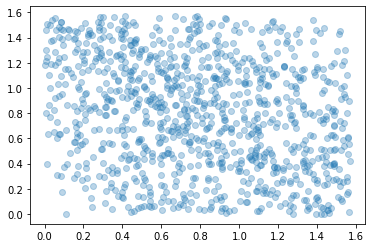

In [4]:
dots = neuman_method(1000, fxy, a, b, f_max)
xs = [x for x, _ in dots]
ys = [y for _, y in dots]

plt.scatter(xs, ys, alpha=0.3)
plt.plot()
plt.show()

### Проверка составляющих функции на независимость

In [5]:
dots = neuman_method(1000, fxy, a, b, f_max)

diffs = [abs(fxy(x, y) - fx(x) * fy(y)) for x, y in dots]
print(np.average(diffs))

0.06526939522947299


$ f(x,y) \not\to f(x) * f(y) $ даже при больших объемах выборки $\rightarrow$ составляющие зависимы


### Условные плотности распределения

In [6]:
f_xy = lambda x, y: fxy(x, y) / fy(y)
f_yx = lambda x, y: fxy(x, y) / fx(x)

$ \displaystyle f(x|y) = {sin(x + y)) \over sin(x) + cos(x)} $

$ \displaystyle f(y|x) = {sin(x + y)) \over sin(y) + cos(y)} $

### Гистограммы составляющих двумерной НСВ и графики их плотностей распределения

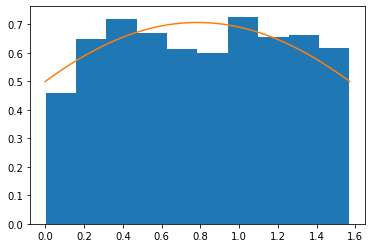

In [7]:
y_range = np.linspace(a, b, 500)
fy_y = [fx(x) for x in y_range]

plt.hist([x for x, _ in dots], density=True)
plt.plot(y_range, fy_y)
plt.show()

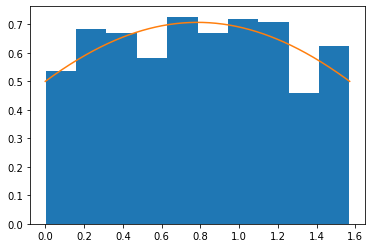

In [8]:
y_range = np.linspace(a, b, 500)
fy_y = [fy(y) for y in y_range]

plt.hist([y for _, y in dots], density=True)
plt.plot(y_range, fy_y)
plt.show()

### 3D график (гистограмма и функция плотности распределения)

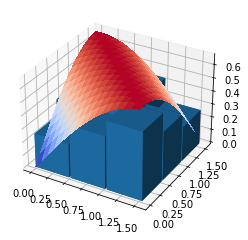

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

hist, xedges, yedges = np.histogram2d(xs, ys, bins=3, range=[[a, b], [a, b]], normed=True)

# Construct arrays for the anchor positions of the 9 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 9 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

X, Y = np.arange(a, b, 0.1), np.arange(a, b, 0.1)
X, Y = np.meshgrid(X, Y)
Z = 2/3 * np.sin(X + Y)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

plt.show()

### Теоретические, точечные значения характеристик двумерной ДСВ

*Математическое ожидание*

In [10]:
def stat_mean(x):
    return sum(x) / len(x)

In [11]:
# M[X] = int( x * f(x) dx ) from a to b
Mx = integrate.quad(lambda x: x * fx(x), a, b)[0]

print('Теоретическое мат. ожидание', Mx)
print('Точечная оценка мат. ожидания', stat_mean(xs))

Теоретическое мат. ожидание 0.7853981633974483
Точечная оценка мат. ожидания 0.7891877264640454


In [12]:
My = integrate.quad(lambda y: y * fy(y), a, b)[0]

print('Теоретическое мат. ожидание', My)
print('Точечная оценка мат. ожидания', stat_mean(ys))

Теоретическое мат. ожидание 0.7853981633974483
Точечная оценка мат. ожидания 0.7913404026361657


*Дисперсия*

In [13]:
def stat_variance(x, mean):
    return sum((_x - mean) ** 2 for _x in x) / len(x)

In [14]:
# D[X] = M[X^2] - M[X]^2
Dx = integrate.quad(lambda x: x ** 2 * fx(x), a, b)[0] - Mx ** 2

print('Теоретическая дисперсия', Dx)
print('Точечная оценка дисперсии', stat_variance(xs, stat_mean(xs)))

Теоретическая дисперсия 0.18764660186298154
Точечная оценка дисперсии 0.1802533189928005


In [15]:
Dy = integrate.quad(lambda y: y ** 2 * fy(y), a, b)[0] - My ** 2

print('Теоретическая дисперсия', Dy)
print('Точечная оценка дисперсии', stat_variance(ys, stat_mean(ys)))

Теоретическая дисперсия 0.18764660186298154
Точечная оценка дисперсии 0.18835102850265403


*Коэффициент корреляции Пирсона*

$ 
{\displaystyle \rho _{X, Y}={ {M} (XY) - {M} (X) {M} (Y) \over {\sqrt { {M} (X^{2}) - {M} (X)^{2}}}\cdot {\sqrt { {M} (Y^{2})- {M} (Y)^{2}}}}} 
$

In [16]:
Mxy = integrate.dblquad(lambda x, y: x * y * fxy(x, y), a, b,
    lambda _: a, lambda _: b)[0]

correlation = (Mxy - Mx * My) / np.sqrt(Dx * Dy)

Статистическая оценка коэффициента корреляции вычисляется по формуле:

$
{\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}
$

In [17]:
def stat_correlation(x, y, Mx, My):
    numerator = sum((_x - Mx) * (_y - My) for _x, _y in zip(x, y))
    sum_x2 = sum((_x - Mx) ** 2 for _x in x)
    sum_y2 = sum((_y - My) ** 2 for _y in y)
    return numerator / np.sqrt(sum_x2 * sum_y2)

In [18]:
print('Теоретический коэффициент корреляции', correlation)
print('Точечная оценка коэффициента корреляции', stat_correlation(xs, ys, stat_mean(xs), stat_mean(ys)))

Теоретический коэффициент корреляции -0.24542916213754049
Точечная оценка коэффициента корреляции -0.2434720718194052


### Интервальные оценки характеристик двумерной ДСВ

In [19]:
# s^2 - исправленная выборочная дисперсия
def s2(x, Mx):
    return sum((_x - Mx) ** 2 for _x in x) / (len(x) - 1)

In [20]:
# Standard error of the mean - стандартное отклонение
def sem(x, s2):
    return np.sqrt(s2 / len(x))

print(sem(xs, s2(xs, stat_mean(xs))))
print(stats.sem(xs))

0.013432563148764499
0.013432563148764502


In [21]:
alpha = 0.99

*Доверительные интервалы математического ожидания*

In [22]:
def ci_mean(x, alpha):
    m = stat_mean(x)
    se = sem(x, s2(x, m))
    return m - alpha * se, m + alpha * se

In [23]:
print("Доверительный интервал мат. ожидания X", ci_mean(xs, alpha))

Доверительный интервал мат. ожидания X (0.7758894889467686, 0.8024859639813223)


In [24]:
print("Доверительный интервал мат. ожидания Y", ci_mean(ys, alpha))

Доверительный интервал мат. ожидания Y (0.7777467412211488, 0.8049340640511825)


*Доверительные интервалы дисперсии*

In [25]:
# Confidential interval for variance
def ci_variance(x, alpha):
    a = (1 - alpha) / 2
    n = len(x)
    _s2 = s2(x, stat_mean(x))
    left = (n - 1) * _s2 / stats.chi2.ppf(1 - a, df=n - 1)
    right = (n - 1) * _s2 / stats.chi2.ppf(a, df=n - 1)
    return left, right

In [26]:
print("Доверительный интервал дисперсии X", ci_variance(xs, alpha))

Доверительный интервал дисперсии X (0.16124417071537311, 0.2030746135271193)


In [27]:
print("Доверительный интервал дисперсии Y", ci_variance(ys, alpha))

Доверительный интервал дисперсии Y (0.16848791225592402, 0.21219754806367597)


*Доверительный интервал коэффициента корреляции*

In [28]:
def ci_correlation(x, y, alpha):
    r = stat_correlation(x, y, stat_mean(x), stat_mean(y))
    z = 1/2 * np.log((1 + r) / (1 - r))
    z_crit = stats.norm.ppf(1 - alpha / 2)
    se = 1 / np.sqrt(len(x) - 3)
    left_z, right_z = (z - z_crit * se, z + z_crit * se)
    left, right = np.tanh(left_z), np.tanh(right_z)
    return left, right

In [29]:
print("Доверительный интервал коэффициента корреляции", ci_correlation(xs, ys, alpha))

Доверительный интервал коэффициента корреляции (-0.24384544467198419, -0.24309862679169783)


## Задание 2.
Написать программу, реализующую метод формирования двумерной ДСВ.

In [30]:
def generate_dsv(x, y, P):
    n, m = len(x), len(y)
    q = [sum(P[:, i]) for i in range(n)]
    Fx = [sum(q[:k + 1]) for k in range(n)]

    x_i = 0
    e = random()
    while e > Fx[x_i]:
        x_i += 1

    Fy = [sum(P[:k + 1, x_i]) for k in range(m)]

    y_i = 0
    e = random() * max(Fy)
    while e > Fy[y_i]:
        y_i += 1
        
    return x[x_i], y[y_i]

In [31]:
x = [1, 2, 3, 4, 5]
y = [6, 7, 8, 9, 10]

n = len(x)
m = len(y)

P = np.array(
    [[0.05, 0.01, 0.05, 0.03, 0.10],
     [0.09, 0.03, 0.06, 0.14, 0.04],
     [0.05, 0.01, 0.03, 0.01, 0.05],
     [0.03, 0.01, 0.01, 0.03, 0.04],
     [0.04, 0.03, 0.03, 0.02, 0.01]])

generate_dsv(x, y, P)

(3, 9)

In [32]:
N = 10000

x_values = []
y_values = [] 

for _ in range(N):
    _x, _y = generate_dsv(x, y, P)
    x_values.append(_x)
    y_values.append(_y)

In [33]:
p_x = [sum(P[:, i]) for i in range(n)]
p_y = [sum(P[j, :]) for j in range(m)]

p_x_imp = [x_values.count(_x) / N for _x in x]
p_y_imp = [y_values.count(_y) / N for _y in y]

In [34]:
print(f"{p_x}\n{p_x_imp}\n")
print(f"{p_y}\n{p_y_imp}\n")

[0.26, 0.09, 0.18000000000000002, 0.23, 0.24000000000000002]
[0.2632, 0.0967, 0.1781, 0.2294, 0.2326]

[0.24000000000000002, 0.36, 0.15, 0.12, 0.13]
[0.2308, 0.3601, 0.1517, 0.1263, 0.1311]



### Проверить составляющие двумерной ДСВ на независимость

In [35]:
def find_avg_difference(P, p_x, p_y): 
    diffs = []
    for i in range(len(p_x)):
        for j in range(len(p_y)):
            diffs.append(abs(P[j, i] - p_x[i] * p_y[j]))
    return np.average(diffs)

avf_diff = find_avg_difference(P, p_x, p_y)
print(f"{avf_diff} -> 0, следовательно можно назвать X, Y независимыми")

0.014328 -> 0, следовательно можно назвать X, Y независимыми


### Найти условные вероятности

In [36]:
p_yx = np.copy(P)
for i in range(n):
    for j in range(m):
        p_yx[j, i] /= p_x[i]

print(p_yx)


p_xy = np.copy(P)
for i in range(n):
    for j in range(m):
        p_xy[j, i] /= p_y[j]
    
print(p_xy)

[[0.19230769 0.11111111 0.27777778 0.13043478 0.41666667]
 [0.34615385 0.33333333 0.33333333 0.60869565 0.16666667]
 [0.19230769 0.11111111 0.16666667 0.04347826 0.20833333]
 [0.11538462 0.11111111 0.05555556 0.13043478 0.16666667]
 [0.15384615 0.33333333 0.16666667 0.08695652 0.04166667]]
[[0.20833333 0.04166667 0.20833333 0.125      0.41666667]
 [0.25       0.08333333 0.16666667 0.38888889 0.11111111]
 [0.33333333 0.06666667 0.2        0.06666667 0.33333333]
 [0.25       0.08333333 0.08333333 0.25       0.33333333]
 [0.30769231 0.23076923 0.23076923 0.15384615 0.07692308]]


### Построить гистограммы составляющих двумерной ДСВ

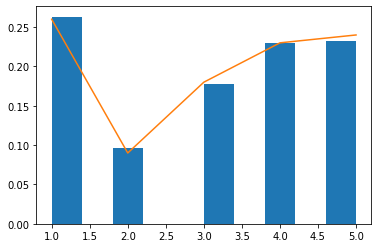

In [37]:
plt.hist(x_values, weights=[1/N]*N)
plt.plot(x, p_x) 
plt.show()

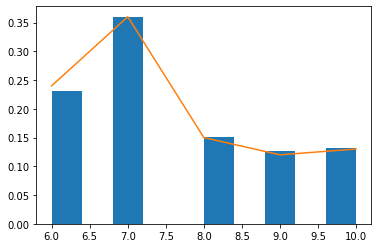

In [38]:
plt.hist(y_values, weights=[1/N]*N)
plt.plot(y, p_y)
plt.show()

### Построить 3D гистограмму

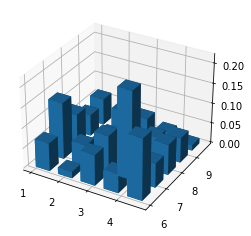

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

hist, xedges, yedges = np.histogram2d(x_values, y_values, bins=5, range=[[min(x), max(x)], [min(y), max(y)]], normed=True)

# Construct arrays for the anchor positions of the 9 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 9 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

### Вычислить теоретические, точечные и интервальные значения характеристик двумерной ДСВ (математическое ожидание, дисперсия, корреляция)

In [40]:
def discrete_mean(x, p_x):
    return sum([x[i] * p_x[i] for i in range(len(x))])

def discrete_variate(x, p_x, M):
    return sum([(x[i] ** 2) * p_x[i] for i in range(len(x))]) - M ** 2

In [41]:
Mx = discrete_mean(x, p_x)
My = discrete_mean(y, p_y)
Mx_imp = discrete_mean(x, p_x_imp)
My_imp = discrete_mean(y, p_y_imp)

print('Теоретическое значение m[x]', Mx)
print('Точечная оценка m[x]', Mx_imp)
print('Теоретическое значение m[y]', My)
print('Точечная оценка m[y]', My_imp)

Теоретическое значение m[x] 3.1
Точечная оценка m[x] 3.0715000000000003
Теоретическое значение m[y] 7.54
Точечная оценка m[y] 7.5668


In [42]:
Dx = discrete_variate(x, p_x, Mx)
Dy = discrete_variate(y, p_y, My)
Dx_imp = discrete_variate(x, p_x_imp, Mx_imp)
Dy_imp = discrete_variate(y, p_y_imp, My_imp)

print('Теоретическое значение D[y]', Dy)
print('Точечная оценка D[y]', Dy_imp)
print('Теоретическое значение D[x]', Dx)
print('Точечная оценка D[x]', Dx_imp)

Теоретическое значение D[y] 1.7484000000000037
Точечная оценка D[y] 1.7463377599999959
Теоретическое значение D[x] 2.3100000000000005
Точечная оценка D[x] 2.304187749999997


In [43]:
Mxy = sum([sum([x * y * P[j, i] for j, y in enumerate(y)]) for i, x in enumerate(x)])

correlation = (Mxy - Mx * My) / np.sqrt(Dx * Dy)
corr_imp = stat_correlation(x_values, y_values, Mx_imp, My_imp)

print('Теоретическое значение коэффициента корреляции', correlation)
print('Точечная оценка коэффициента корреляции', corr_imp)

Теоретическое значение коэффициента корреляции -0.1512680452353972
Точечная оценка коэффициента корреляции -0.1761877409910583


In [44]:
print('Доверительный интервал мат. ожидания X', ci_mean(x_values, alpha))

Доверительный интервал мат. ожидания X (3.0564714928559007, 3.086528507144099)


In [45]:
print('Доверительный интервал мат. ожидания Y', ci_mean(y_values, alpha))

Доверительный интервал мат. ожидания Y (7.553716587546601, 7.579883412453398)


In [46]:
print('Доверительный интервал дисперсии X', ci_variance(x_values, alpha))

Доверительный интервал дисперсии X (2.2226144998521744, 2.390608685103314)


In [47]:
print('Доверительный интервал дисперсии Y', ci_variance(y_values, alpha))

Доверительный интервал дисперсии Y (1.6845136109305454, 1.8118359565876774)


In [48]:
print('Доверительный интервал коэффициента корреляции', ci_correlation(x_values, y_values, alpha))

Доверительный интервал коэффициента корреляции (-0.17630920056902807, -0.1760662760479176)
